In [286]:
import numpy as np
import pandas as pd
from tsfresh import feature_extraction
import os
import seaborn as sns
import re
from collections import defaultdict

In [331]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

In [268]:
def normalize_signal(signal):
    """
    time_series
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [242]:
def normalize_all_signals_in_ds(one_group_ds):
    for signal in one_group_ds.drop('t', axis=1):
        one_group_ds[signal] = normalize_signal(one_group_ds[signal])

In [323]:
# os.chdir('..')
os.getcwd()

'/Users/aolen/master_degree'

In [208]:
labels = pd.DataFrame(columns=['id', 'class', 'label'])
labels.columns
labels.append((pd.Series( [1, 2, 3], index=labels.columns)), ignore_index=True)
# dfObj.append(pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ), ignore_index=True)

,id,class,label
0,1,2,3


In [405]:
def append_signals_dataset(data_directory, signals_dataset = None, labels = None):
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    signal_id = 0
    if not labels:
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    for signal_label, directory in enumerate(data_dir_list):
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*csv)', filename):
                if (signals_dataset) is not None:
                    tmp_df = pd.read_csv(filename)
                    normalize_all_signals_in_ds(tmp_df)
                    tmp_df['id'] = signal_id
                    signals_dataset = signals_dataset.append(tmp_df, ignore_index=True)
                else:
                    signals_dataset = pd.read_csv(filename)
                    normalize_all_signals_in_ds(signals_dataset)
                    signals_dataset['id'] = 0
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../')
    return signals_dataset, labels

In [61]:
ex = pd.read_csv('./data/le_8/1.csv')
ex2 = pd.read_csv('./data/le_8/2.csv')
ex3 = pd.read_csv('./data/more_8/2.csv')

Data preprocessing:
    - dropping U.1 == U
    - changing type
    - generating features

In [406]:
dataset, labels = append_signals_dataset('./data')

In [410]:
# converting data in labels dataframe
labels.label = pd.to_numeric(labels.label)

In [415]:
# Check if data merging with labels
mod_dataset = dataset.drop(['U.1', 'Pgt'], axis=1)
mod_dataset.merge(labels, on='id')

,t,U,Pij,Pg,delta,id,class,label
0,0.01,0.980952,-0.273585,0.657965,-0.953874,0.0,le_8,0
1,0.02,0.980952,-0.273585,0.657965,-0.953874,0.0,le_8,0
2,0.03,0.980952,-0.273585,0.657965,-0.953874,0.0,le_8,0
3,0.04,0.980952,-0.273585,0.657965,-0.953874,0.0,le_8,0
4,0.05,0.980952,-0.273585,0.657965,-0.953874,0.0,le_8,0
...,...,...,...,...,...,...,...,...
7432,1.96,-1.107748,0.546772,0.863101,1.072291,36.0,more_8,1
7433,1.97,-1.094790,0.547869,0.862314,1.064166,36.0,more_8,1
7434,1.98,-1.088311,0.549333,0.861527,1.056041,36.0,more_8,1
7435,1.99,-1.075353,0.550431,0.860739,1.046562,36.0,more_8,1


In [241]:
dataset.id.describe()

count    7437.000000
mean       36.000000
std        21.355592
min         0.000000
25%        18.000000
50%        36.000000
75%        54.000000
max        72.000000
Name: id, dtype: float64

In [418]:
features = defaultdict()
for param in mod_dataset.loc[:,'U':'delta']:
    features[param] = feature_extraction.extract_features\
    (dataset.loc[:,[param,'id','t']], column_sort='t', column_id='id')

Feature Extraction: 100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


### После обработки каждого сигнала библиотекой tsfresh извлекаем всевозможные признаки, признаки классифицированы по сигналу, из которого были получены (словарь features)
В конечном счете для каждого сигнала сформирован следующий набор данных:

In [421]:
for param in features:
    print("Для параметра", param, "получено", features[param].shape[1], "признака(ов).")

Для параметра U получено 754 признака(ов).
Для параметра Pij получено 754 признака(ов).
Для параметра Pg получено 754 признака(ов).
Для параметра delta получено 754 признака(ов).


In [447]:
# Пример хранящихся признаков
features['U'].index

Float64Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0,
              11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0,
              22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0,
              33.0, 34.0, 35.0, 36.0],
             dtype='float64', name='id')

## Поиск наиболее важных признаков, которые позволят предсказывать результат переходного процесса

In [425]:
# Удаляем фичи количество признаков в которых меньше количества классов
def clear_useless_features(features, threshold=2):
    for feature in features.columns:
        if features[feature].nunique() <= threshold:
            features = features.drop(feature, axis=1)
    return features

In [427]:
modified_features = defaultdict()
for param in features:
    modified_features[param] = clear_useless_features(features[param],
                                                     labels.label.nunique())
    print(f"Число удаленных признаков для {param}:",
          features[param].shape[1] - modified_features[param].shape[1])

Число удаленных признаков для U: 72
Число удаленных признаков для Pij: 72
Число удаленных признаков для Pg: 68
Число удаленных признаков для delta: 70


Поиск признаков, имеющих наибольшую корреляцию с целевой переменной sklearn (Только для регресии и неотрицательных признаков)

In [428]:
def delete_negative_features(X):
    for i in X.columns:
        if X[i].min() < 0:
            X = X.drop(i, axis=1)
    return X

In [365]:
X = delete_negative_features(modified_features['U'])
Y = labels.label
# bestfeatures = SelectKBest(score_func=chi2, k=10)
# fit = bestfeatures.fit(X, labels.label)
# dfscores = pd.DataFrame(fit.scores_)
# dfcolumns = pd.DataFrame(X.columns)
# featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# print(featureScores.nlargest(10,'Score'))

Использование дерева для поиска фич

In [435]:
def plot_features(X, Y):
#     X = modified_features['U']
#     y = labels.label
    model = ExtraTreesClassifier(n_estimators=100)
    model.fit(X,y)
#     print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.show()

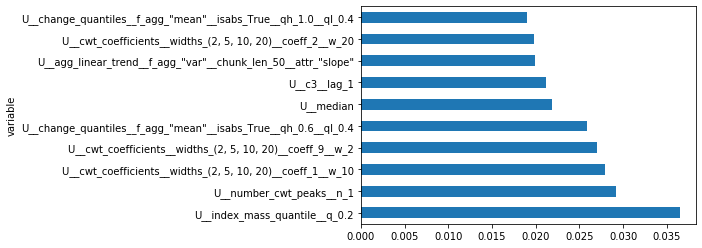

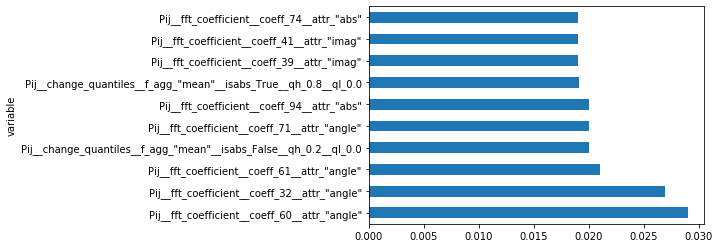

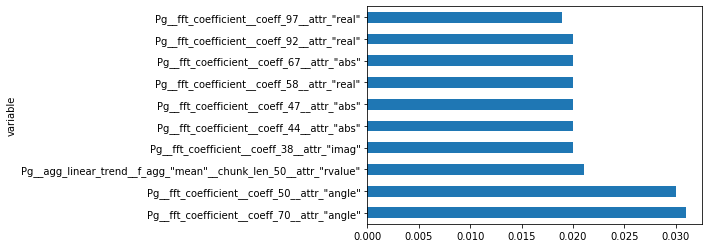

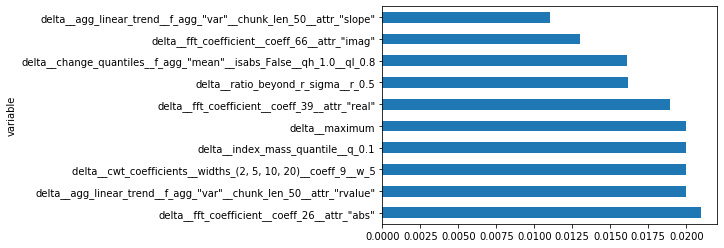

In [437]:
for param in features:
    plot_features(modified_features[param], labels.label)

Построим тепловую карту фич, взятых из предыдущего шага

In [460]:
data = features['U'].iloc[:,0:50].join(labels.loc[:,['label']], on='id')

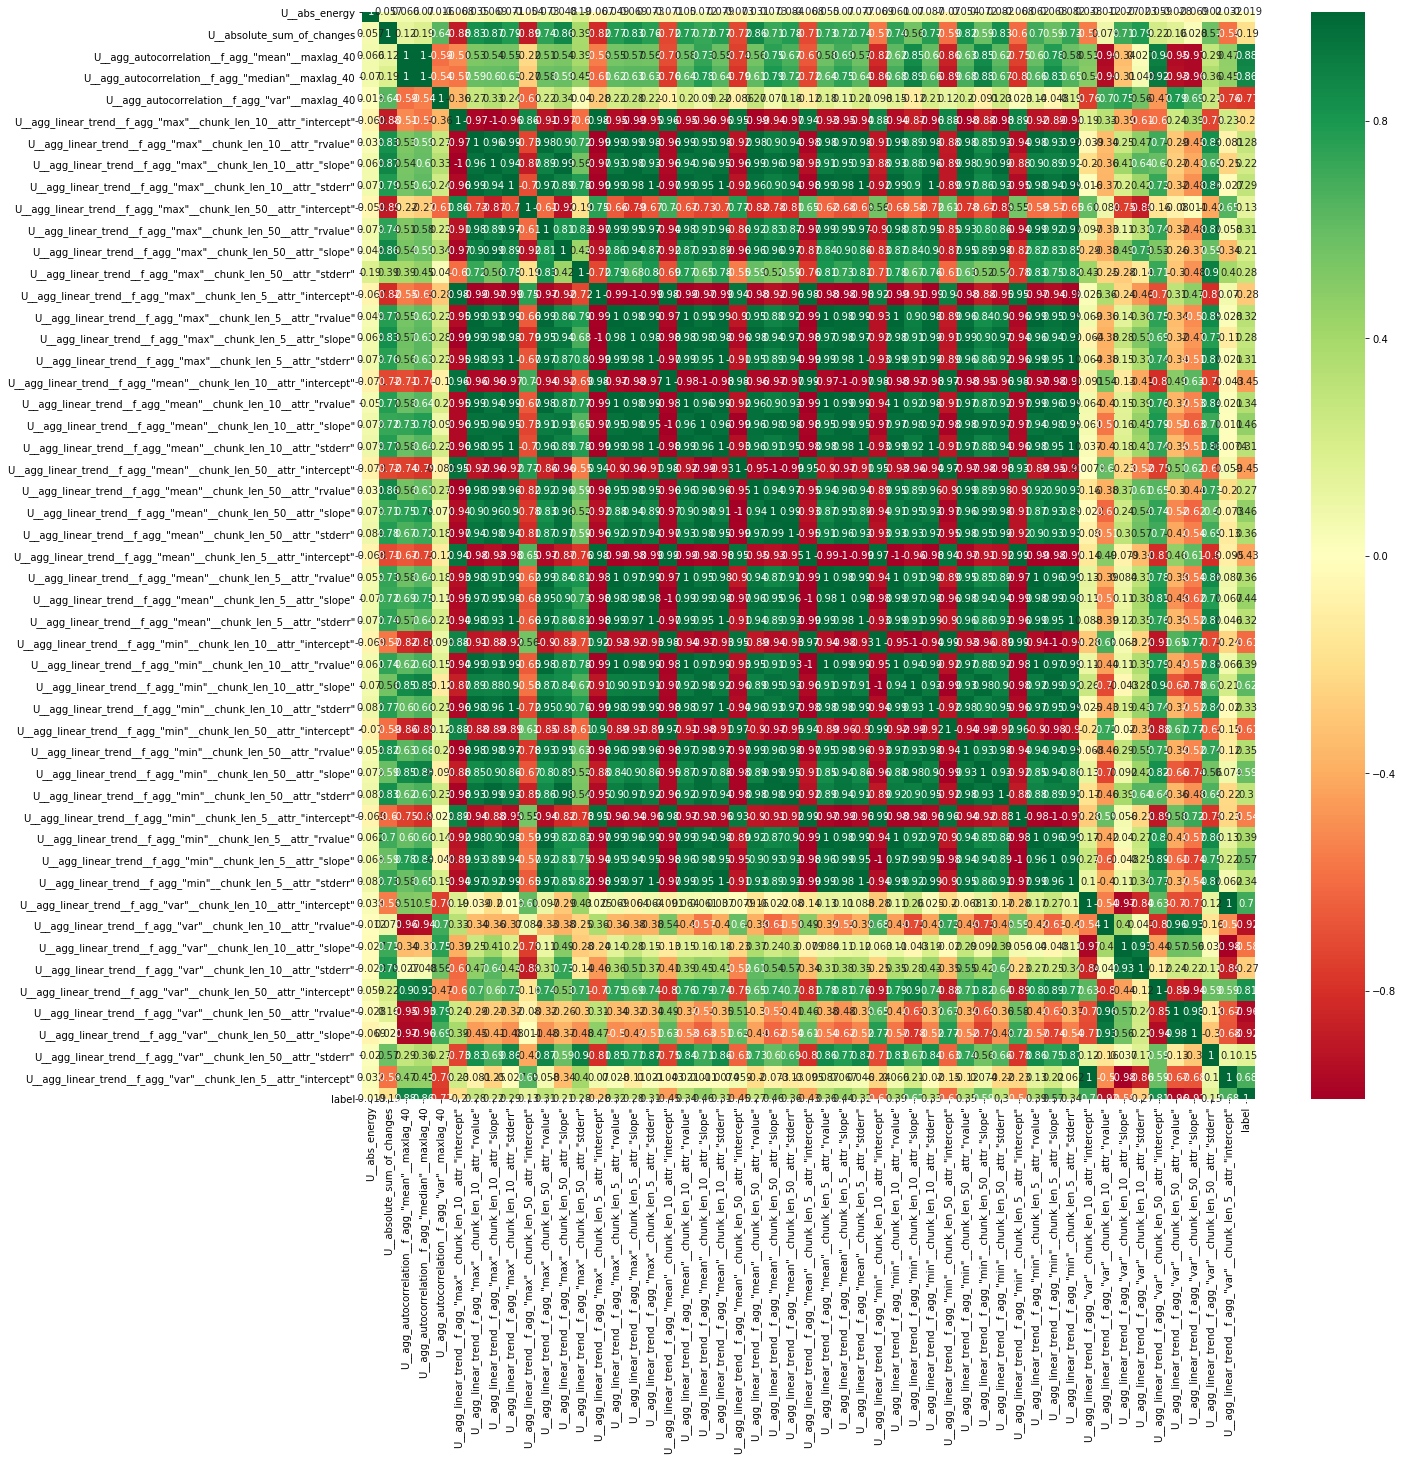

In [462]:
#get correlations of each features in dataset
# data = features['U'].join(labels.loc[:,['id', 'label']])
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [463]:
!git status
!git add .
!git commit -m "featu"

error: key does not contain a section: name
error: key does not contain a section: email
On branch master
Your branch is up-to-date with 'origin/master'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	deleted:    Data_preprocessing.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	Data_forming.ipynb
	Data_processing.ipynb
	tsfresh/

no changes added to commit (use "git add" and/or "git commit -a")
